<a href="https://colab.research.google.com/github/matilda1740/fl_dp_he/blob/main/0_baseFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-federated tensorflow-privacy tenseal wandb

1. Loading Datasets - MNIST (IID) and CheXpert (Non-IID)

In [32]:
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import random
import matplotlib.pyplot as plt
# Load EMNIST data (characters, not digits)
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# View client IDs
client_ids = emnist_train.client_ids
print(f'Number of clients: {len(client_ids)}')

# Sample 10 random clients for simulation (IID-style)
import random
sample_clients = random.sample(client_ids, 10)

# Preprocessing: map each client's data into batches and format
def preprocess(dataset):
    return (dataset
            .map(lambda e: (tf.reshape(e['pixels'], [-1]), e['label']))  # flatten 28x28
            .batch(20)
            .prefetch(2))

# Create federated data for selected clients
federated_train_data = [
    preprocess(emnist_train.create_tf_dataset_for_client(client))
    for client in sample_clients
]

# Create a simple fully connected model
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(784,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(62, activation='softmax')  # 62 classes in EMNIST
    ])

# Wrap Keras model for use with TFF
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Federated averaging process
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0)
)

# Initialize process
state = iterative_process.initialize()

# Store metrics
train_losses = []
train_accuracies = []

# Train for 10 rounds
for round_num in range(1, 11):
    state, metrics = iterative_process.next(state, federated_train_data)
    train_metrics = metrics['client_work']['train']
    loss = train_metrics['loss']
    acc = train_metrics['sparse_categorical_accuracy']
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f'Round {round_num}: loss = {loss:.4f}, accuracy = {acc:.4f}')

Number of clients: 3383
Round 1: loss = 3.9880, accuracy = 0.0642
Round 2: loss = 3.0893, accuracy = 0.0687
Round 3: loss = 2.8247, accuracy = 0.0587
Round 4: loss = 2.7565, accuracy = 0.0620
Round 5: loss = 2.7111, accuracy = 0.0587
Round 6: loss = 2.6729, accuracy = 0.0576
Round 7: loss = 2.6450, accuracy = 0.0620
Round 8: loss = 2.6162, accuracy = 0.0631
Round 9: loss = 2.5934, accuracy = 0.0653
Round 10: loss = 2.5715, accuracy = 0.0698


Plot Training Metrics

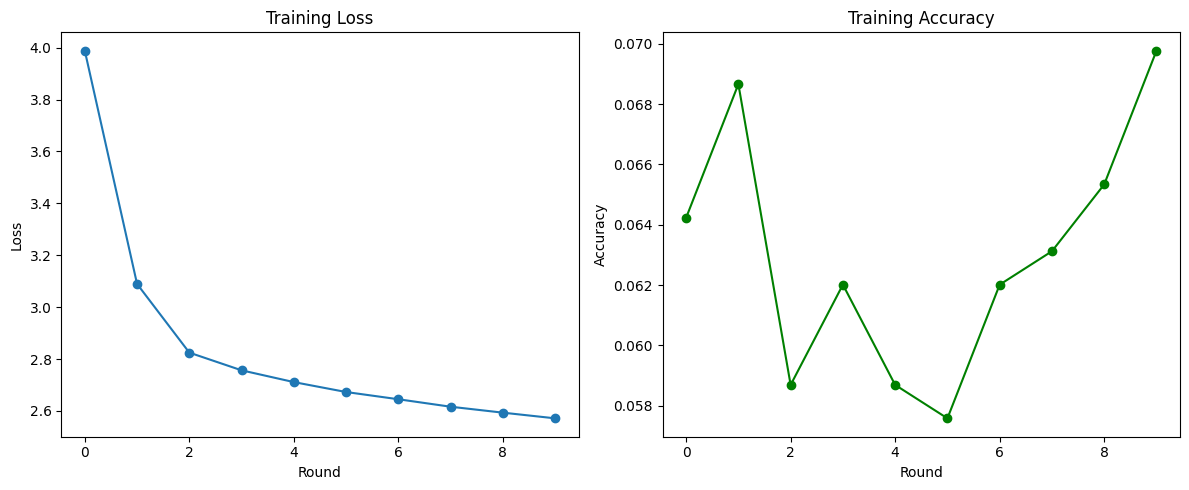

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title('Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Centralized Evaluation on test set

In [34]:
# Preprocess and batch the test dataset
test_dataset = emnist_test.create_tf_dataset_from_all_clients()
test_dataset = preprocess(test_dataset)

# Create a fresh Keras model and load final federated weights into it
final_model = create_keras_model()
model_weights = iterative_process.get_model_weights(state)
model_weights.assign_weights_to(final_model)


# Compile before evaluation
final_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Evaluate
loss, accuracy = final_model.evaluate(test_dataset, verbose=0)
print(f'\nCentralized Test Evaluation — Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Centralized Test Evaluation — Loss: 2.4332, Accuracy: 0.0980
